In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch import save

warnings.filterwarnings(action='ignore', message='Setting attributes')


In [3]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,x,y):
        my_loss = torch.mean(torch.abs((x - y)/y))
        return  my_loss


               load
date               
2009-12-01  7687.64
2009-12-01  7506.77
2009-12-01  7264.11
2009-12-01  7028.90
2009-12-01  6754.74
11712
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=1440, forecast_length=1440, share_thetas=False) at @2360596345992
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=1440, forecast_length=1440, share_thetas=False) at @2360596345992
     | -- GenericBlock(units=64, thetas_dim=2, backcast_length=1440, forecast_length=1440, share_thetas=False) at @2360596345992
| --  Stack Seasonality (#1) (share_weights_in_stack=True)
     | -- SeasonalityBlock(units=64, thetas_dim=1440, backcast_length=1440, forecast_length=1440, share_thetas=True) at @2360745092104
     | -- SeasonalityBlock(units=64, thetas_dim=1440, backcast_length=1440, forecast_length=1440, share_thetas=True) at @2360745092104
     | -- SeasonalityBlock(units=64, thetas_dim=1440, backcast_length=144

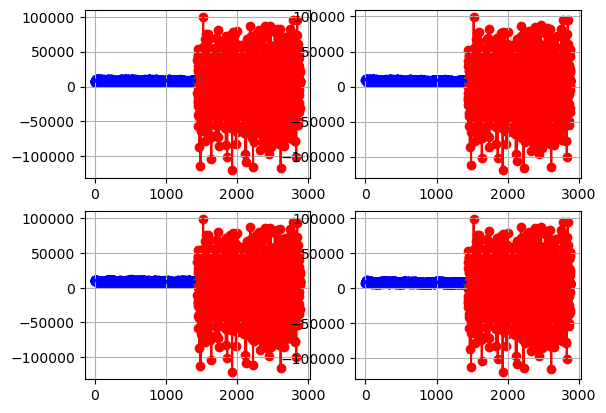

epoch = 0000, grad_step = 000009, tr_loss (epoch) = 10520.264, te_loss (epoch) = 7076.924


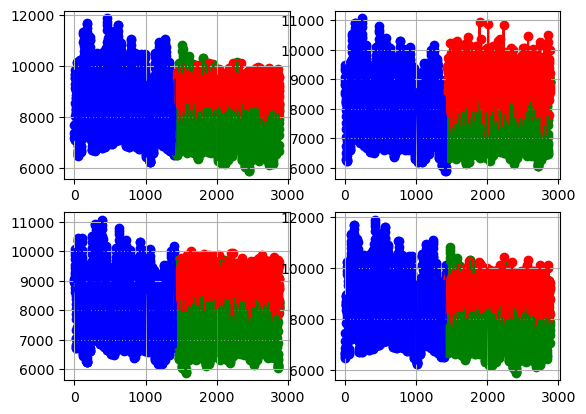

epoch = 0100, grad_step = 000909, tr_loss (epoch) = 11.173, te_loss (epoch) = 8.955


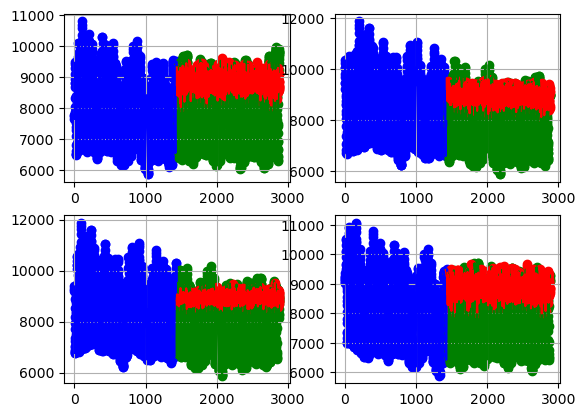

epoch = 0200, grad_step = 001809, tr_loss (epoch) = 10.406, te_loss (epoch) = 7.956


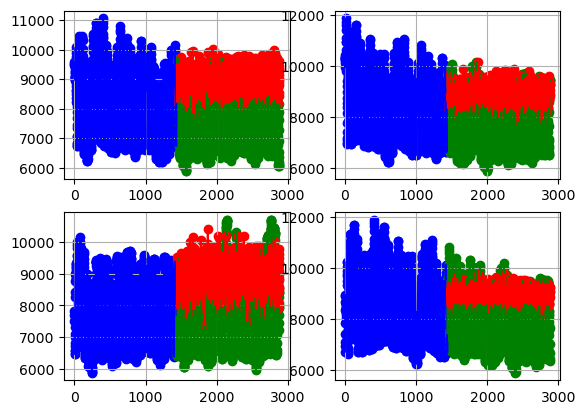

epoch = 0300, grad_step = 002709, tr_loss (epoch) = 10.404, te_loss (epoch) = 8.091


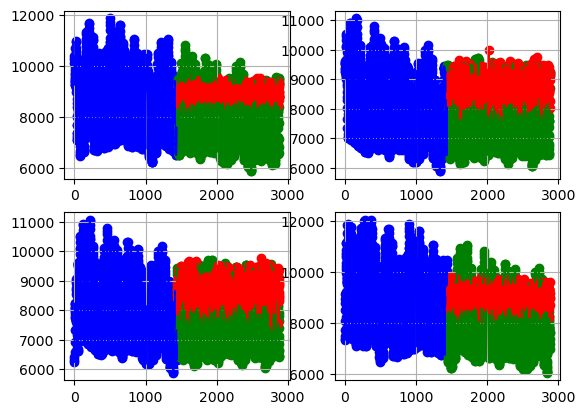

epoch = 0400, grad_step = 003609, tr_loss (epoch) = 10.070, te_loss (epoch) = 7.568


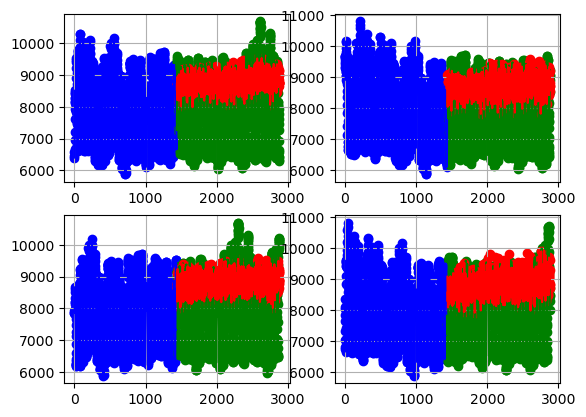

epoch = 0500, grad_step = 004509, tr_loss (epoch) = 9.977, te_loss (epoch) = 7.333


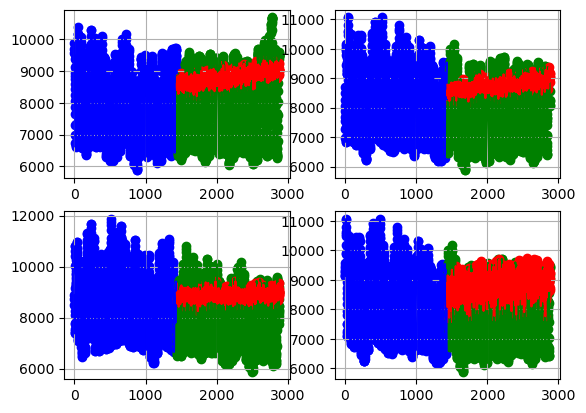

epoch = 0600, grad_step = 005409, tr_loss (epoch) = 9.754, te_loss (epoch) = 7.052


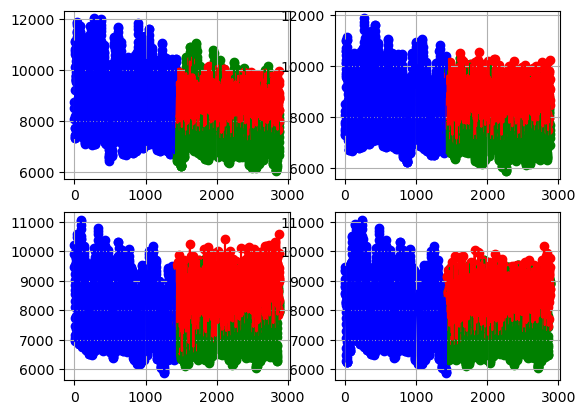

epoch = 0700, grad_step = 006309, tr_loss (epoch) = 10.012, te_loss (epoch) = 7.743


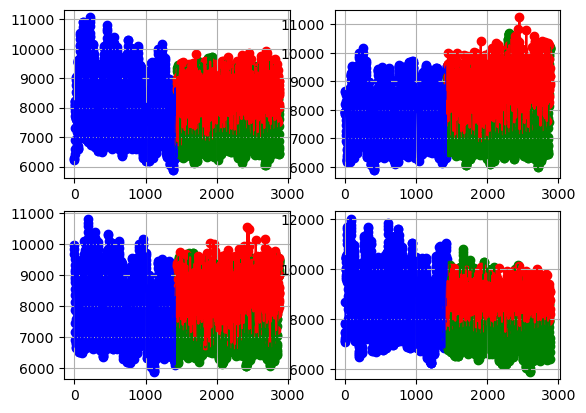

epoch = 0800, grad_step = 007209, tr_loss (epoch) = 9.628, te_loss (epoch) = 7.386


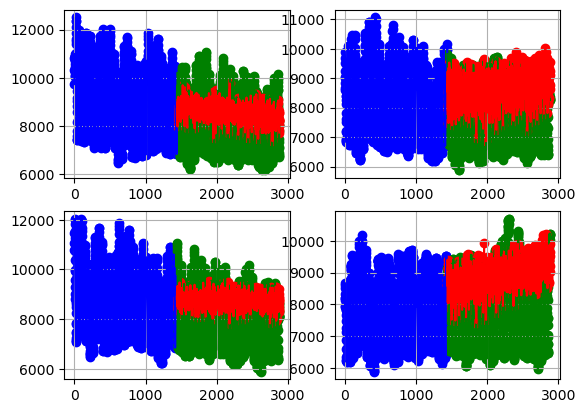

epoch = 0900, grad_step = 008109, tr_loss (epoch) = 8.903, te_loss (epoch) = 5.785


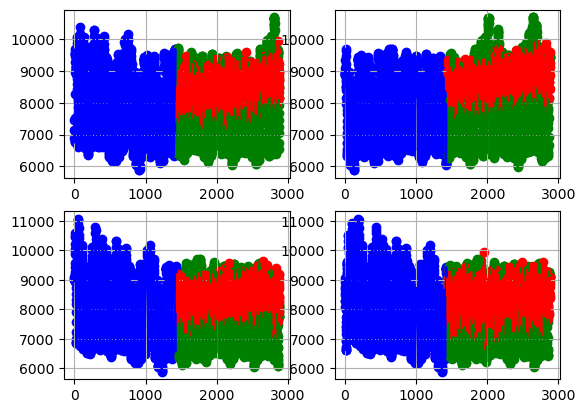

epoch = 1000, grad_step = 009009, tr_loss (epoch) = 8.055, te_loss (epoch) = 5.276


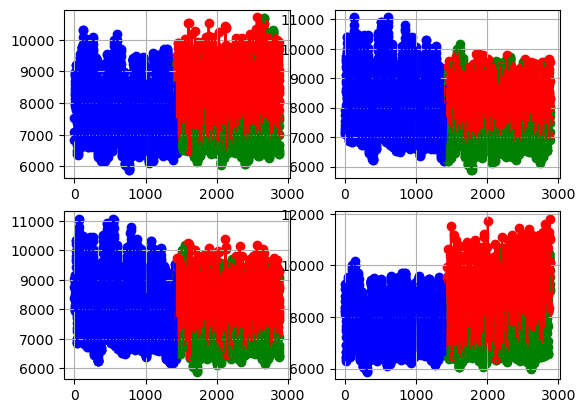

epoch = 1100, grad_step = 009909, tr_loss (epoch) = 7.024, te_loss (epoch) = 5.862
Text [8131.6767578125, 8110.0966796875, 7941.63916015625, 8070.61572265625, 7525.4140625, 7654.54541015625, 7964.1181640625, 7523.70166015625, 7167.0185546875, 7296.05517578125, 7815.326171875, 7825.7998046875, 8383.9609375, 8480.82421875, 8056.2705078125, 8154.84326171875, 8611.7236328125, 8243.5732421875, 8619.671875, 8744.4150390625, 8913.4296875, 8737.3388671875, 8842.744140625, 8496.197265625, 9006.353515625, 9336.2060546875, 9121.859375, 8772.8134765625, 8693.7587890625, 9314.2685546875, 8885.2294921875, 9252.6923828125, 9222.8154296875, 8784.01953125, 8967.1435546875, 9110.2060546875, 9135.28125, 8891.4189453125, 8520.0244140625, 8729.66796875, 8912.4951171875, 8095.9462890625, 8577.701171875, 8724.302734375, 8748.00390625, 7923.31640625, 8313.7509765625, 8119.1630859375, 8068.1884765625, 8042.5458984375, 7431.5458984375, 8163.712890625, 8074.08935546875, 7856.03369140625, 8404.8740234375, 8127.37

In [10]:
def main():
    forecast_length = 48 * 30
    backcast_length = forecast_length
    # backcast_length = forecast_length*7
    batch_size = 48*30  # greater than 4 for viz

    electric = pd.read_csv('data/48/48.csv', index_col=0, parse_dates=True)

    print(electric.head())
    electric = electric.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(electric) - forecast_length):

        x.append(electric[epoch - backcast_length:epoch])
        y.append(electric[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    print(c)

    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]

    # normalization.  归一化
    norm_constant = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(
        stack_types=( NBeatsNet.GENERIC_BLOCK,NBeatsNet.SEASONALITY_BLOCK,NBeatsNet.TREND_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units = 64,
        thetas_dim=(2,8,3),
        share_weights_in_stack=True
    )
    # net = torch.load("model(wu).pth")
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())
    # optimiser = optim.Adam(lr=0.002, params=net.parameters())


    grad_step = 0
    for epoch in range(1200):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            A=CustomLoss()
            # loss = A(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        B=CustomLoss()
        # test_loss = B(forecast, torch.tensor(y_test, dtype=torch.float).to(net.device)).item()
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    B = forecast.flatten()
    C= B * norm_constant
    NC = C.detach().numpy()
    NNC = NC.tolist()
    # Text=NNC[len(NNC)-30::]
    # print('Text',Text)

    # avg=[]
    # # 当len（forecast）< forecast_length
    # if  forecast_length>len(forecast):
    #    for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif forecast_length-1>=i>len(forecast)-1:
    #          avg.append(np.mean(NNC[i:forecast_length * i + 1:6]))
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #    pass
    #
    # # 当len（forecast）= forecast_length
    # elif forecast_length == len(forecast):
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=len(forecast)-1:
    #          N = np.mean(NNC[i :4 * i + 1 : 6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast) + forecast_length - 2 > i > forecast_length-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC):6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass
    #
    # # 当len（forecast）> forecast_length
    # else:
    #     for i in range(0,len(forecast)+forecast_length-1):
    #       if i == 0:
    #          avg.append(NNC[i])
    #          pass
    #
    #       elif 0<i<=forecast_length-1:
    #          N = np.mean(NNC[i:forecast_length * i + 1:6])
    #          avg.append(N)
    #          pass
    #
    #       elif len(forecast)>i>forecast_length-1:
    #          t = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * t : len(NNC) - (len(forecast)-i) * forecast_length + 1 : 6]))
    #          pass
    #
    #       # 在这里下端触底了
    #       elif len(forecast) + forecast_length - 2 > i >= len(forecast)-1:
    #          j = i - forecast_length + 1
    #          avg.append(np.mean(NNC[i + 6 * j:len(NNC) - 1 : 6]))
    #          pass
    #
    #       else:
    #          c = i - forecast_length+1
    #          avg.append(NNC[ i + c * 6 ])
    #          pass
    #     pass

    # print('avg',avg)
    # print(type(avg))
    # print('len(avg)',len(avg))

    Text=NNC[len(NNC)-48*30::]
    print('Text',Text)


    TRU = electric[len(electric)-48*30::]
    print('TRU',TRU)
    print('TRU',len(TRU))
    print(type(TRU),type(TRU))

    MAPE = np.mean(abs(TRU - Text) / TRU)
    print('mape',MAPE)




    # MAPE

    # APE=[]
    # for day in range(len(TRU)):
    #     per_err = (TRU[day] - Text[day]) / TRU[day]
    #     per_err = abs(per_err)
    #     APE.append(per_err)
    #     MAPE = sum(APE)/len(APE)
    # print(len(TRU),'天总共预测电量的mape的平均值')
    # print('mape :',round(MAPE, 2))
    # print('mape % :',round(MAPE*100, 2),'%')
    # print('---------------------------------------------')
    # EVE=[]
    # for day in range(len(TRU)):
    #     per_err1 = abs((TRU[day] - Text[day]) / TRU[day])
    #     EVE.append(per_err1*100)
    # print(EVE)
    #
    # torch.save(net,'STL_N-BEATS(simple8).pth')


if __name__ == '__main__':
    main()